In [61]:
import numpy as np
import anndata

In [4]:
from rich import print as rprint
from rich.traceback import install
install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7fcd363ce640>>

In [4]:
import importlib
import pipeline
pipeline = importlib.reload(pipeline)

In [25]:
data_dir = '/home/tiankang/wusuowei/data/single_cell/babel/snareseq_GSE126074/GSE126074_AdBrainCortex_SNAREseq_cDNA.counts.mtx.gz'

In [26]:
X_sparse = pipeline.read_mtx(data_dir)

33160 10309 9805813


In [30]:
X_sparse.shape

(10309, 33160)

In [31]:
genes = np.arange(X_sparse.shape[1])

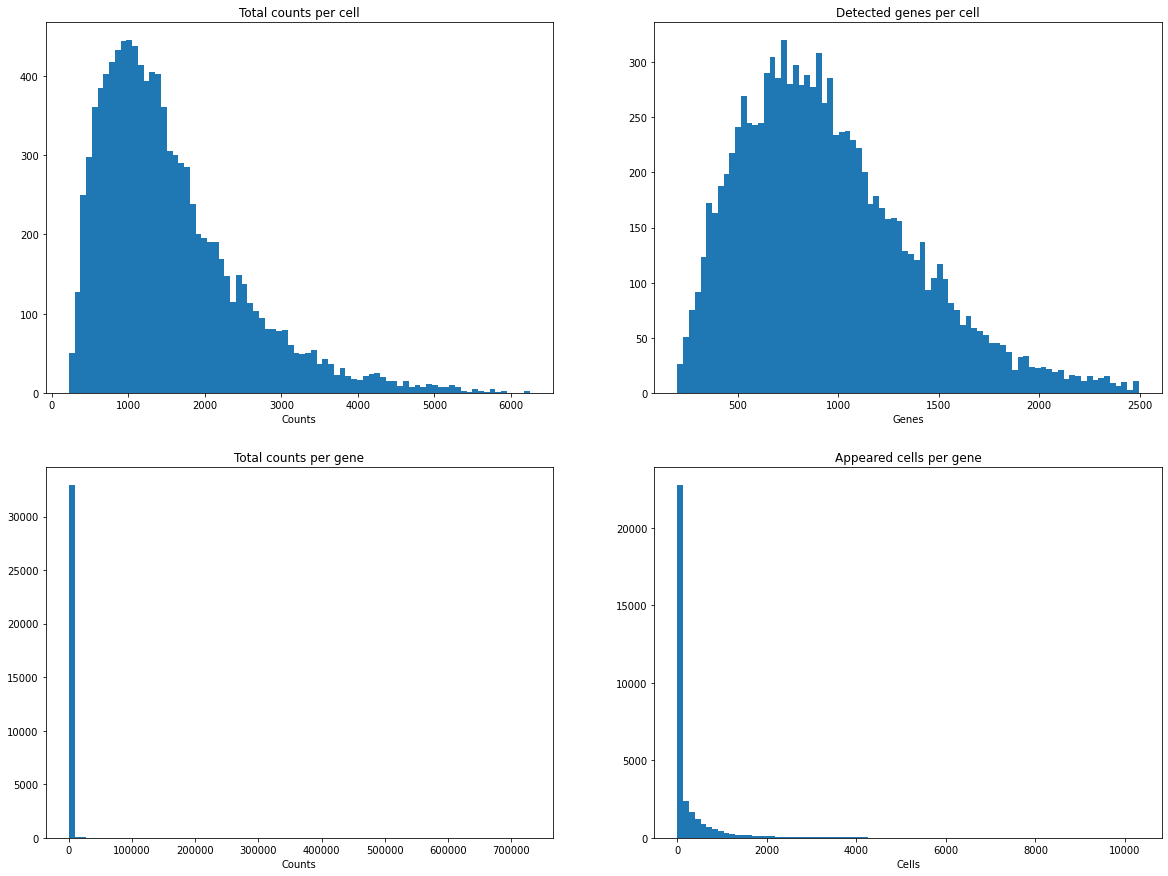

In [28]:
pipeline.plot_qc(X_sparse, './imgs/snare_seq/preqc.jpg')

(10309, 33160)
(10309, 13183)
Median: 1242.0


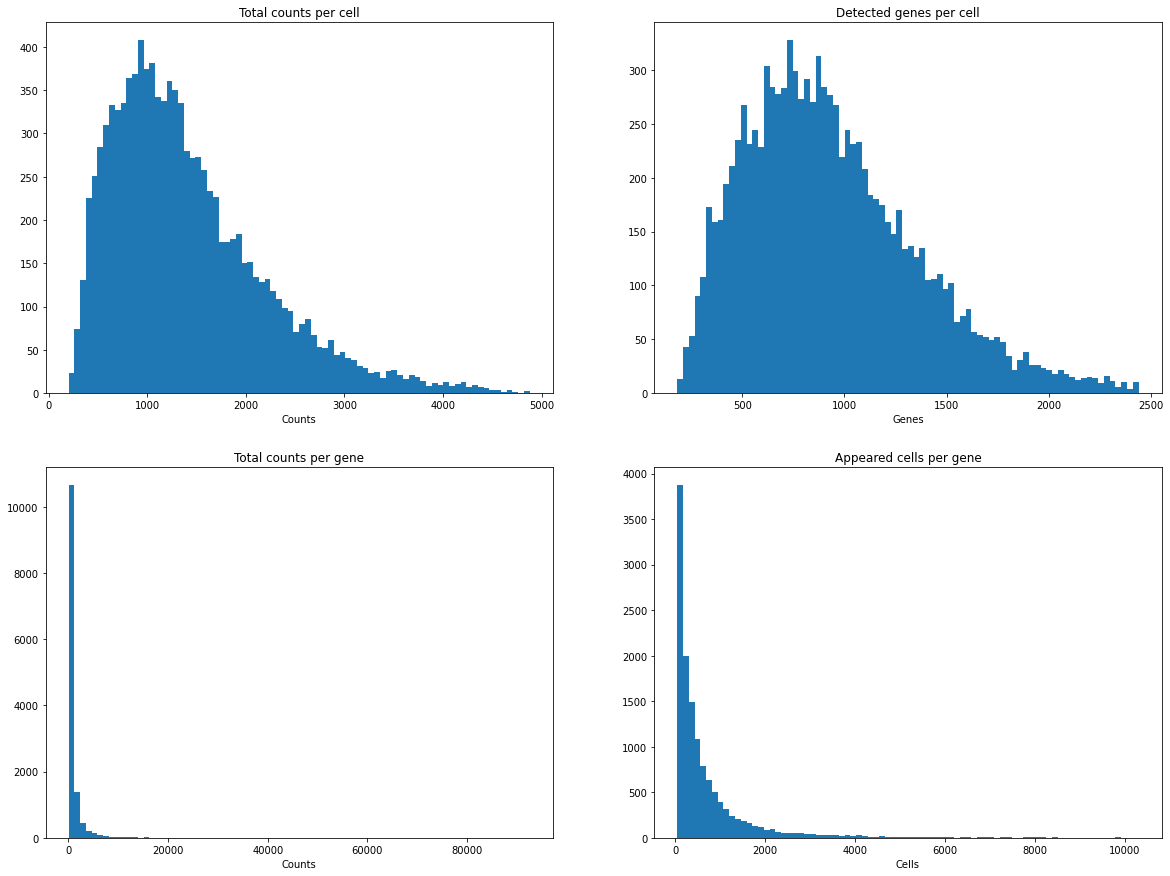

In [45]:
X_sparse, good_genes, _ = pipeline.normalize(X_sparse, plot=True, postqc_path='./imgs/snare_seq/postqc.jpg', gene_min_cells=50, gene_min_counts=100)

In [46]:
umap_object, X_umap = pipeline.umap(X_sparse, n_components=2)

In [59]:
labels = X_umap.sum(axis=1)

In [60]:
fig = pipeline.plot(X_umap, labels=labels)
fig.write_image('./imgs/snare_seq/umap.jpg')

In [62]:
data = anndata.AnnData(X_sparse)
data.write('/home/tiankang/wusuowei/data/single_cell/babel/snareseq_GSE126074/rna_processed.h5ad')

In [63]:
np.save('/home/tiankang/wusuowei/data/single_cell/babel/snareseq_GSE126074/labels.npy', labels)

In [1]:
from typing import Type

import numpy as np
import torch
import pytorch_lightning as pl
from torchmetrics.functional import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from train import Net
from datamodule import scRNADataModule, SNAREDataModule
from utils import knn
import pipeline

In [2]:
@torch.no_grad()
def test_npid_snare(
    net,
    checkpoint,
    datamodule,
    data_dir,
    labels_path,
    umap_path,
    hparams_file=None,
):
    model = net.load_from_checkpoint(checkpoint, hparams_file=hparams_file)
    labels = np.load(labels_path)
    module = datamodule(data_dir, model.hparams.batch_size)
    model.eval()
    module.setup(stage="fit")
    train_loader = module.train_dataloader()
    output = torch.zeros(module.length_train, model.hparams.feature_dim)
    for imgs, _, indices in tqdm(train_loader):
        output[indices] = model(imgs)
    # _, X_umap = pipeline.umap(output.cpu().numpy(), n_components=2)
    fig = pipeline.plot(output.cpu().numpy(), labels)
    # fig.write_image(umap_path, width=700, height=500)
    return fig

In [5]:
checkpoint = '/home/tiankang/wusuowei/deeplearning/single_cell/self_supervised/lightning_logs/version_76/checkpoints/epoch=2-step=242.ckpt'
data_dir = "/home/tiankang/wusuowei/data/single_cell/babel/snareseq_GSE126074/"
heatmap_path = './imgs/snare_seq/heatmap_1.jpg'
umap_path = './imgs/snare_seq/umap_version76.jpg'

labels_path = "/home/tiankang/wusuowei/data/single_cell/babel/snareseq_GSE126074/train/labels.npy"
test_npid_snare(Net, checkpoint, SNAREDataModule, data_dir, labels_path, umap_path)


(10309, 13183)


  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
checkpoint = '/home/tiankang/wusuowei/deeplearning/single_cell/self_supervised/lightning_logs/version_77/checkpoints/epoch=29-step=2429.ckpt'
data_dir = "/home/tiankang/wusuowei/data/single_cell/babel/snareseq_GSE126074/"
heatmap_path = './imgs/snare_seq/heatmap_1.jpg'
umap_path = './imgs/snare_seq/umap_version77.jpg'

labels_path = "/home/tiankang/wusuowei/data/single_cell/babel/snareseq_GSE126074/train/labels.npy"
test_npid_snare(Net, checkpoint, SNAREDataModule, data_dir, labels_path, umap_path)


(10309, 13183)


  0%|          | 0/81 [00:00<?, ?it/s]